# 데이터와 학습된 모델 파일
폴더 : https://drive.google.com/drive/folders/1TyrVSxVBpntEquxlD3jW6YCQBcag8Giu?usp=sharing

- face.zip : https://drive.google.com/file/d/1cVW_QF2Q7Xuq3AhEyDgyzRkua1W590S2/view?usp=sharing
- face_test.zip : https://drive.google.com/file/d/1bTL41-OrLW8lvjCNN9L8GheVpyZcChzK/view?usp=sharing
- face_classification.h5 : https://drive.google.com/file/d/1-5iZfvC82wRvANAEdaTaKT2JTFJfpJlP/view?usp=sharing
- face_detection_last.weights : https://drive.google.com/file/d/1E8Dhv2wbeW-9UCXM1MlYHqyqvncsxAH5/view?usp=sharing

위 파일 들을 GDRIVE_PATH 위치에 가져다 놓는다.

# 설정

In [1]:
HOME = "/content"

In [2]:
GDRIVE_PATH = "/gdrive/MyDrive/tmp/face"
FACE_DETECTION_MODEL_FILE = "face_detection_last.weights"
FACE_CLASSIFICATION_MODEL_FILE = "face_classification.h5"
DATA_FILE_NAME = "face.zip"
class_names = [ "etc", "iu", "son" ]

# 드라이브 연결

In [4]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# 얼굴 탐지 학습

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2

## 프로젝트 다운로드

In [6]:
%cd {HOME}
!git clone https://github.com/AlexeyAB/darknet.git

Cloning into 'darknet'...
remote: Enumerating objects: 15395, done.
remote: Total 15395 (delta 0), reused 0 (delta 0), pack-reused 15395
Receiving objects: 100% (15395/15395), 14.02 MiB | 18.26 MiB/s, done.
Resolving deltas: 100% (10352/10352), done.


OpenCV, GPU, CuDNN 사용 관련 설정하고 컴파일

In [7]:
%cd {HOME}
%cd darknet

/content
/content/darknet


## 컴파일 설정 파일 수정

In [8]:
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

## 컴파일

In [9]:
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_

## 데이터 준비
- darknet/data/obj에 latops_labeled.zip 압축 풀기
- classes.names와 training.data 파일 생성
- training.txt 파일 생성


### data/obj/laptops_labeled 폴더에 압축 풀기

In [10]:
!rm -rf data/obj
!mkdir data/obj
!unzip /gdrive/MyDrive/tmp/face/face.zip -d data/obj/face

Archive:  /gdrive/MyDrive/tmp/face/face.zip
  inflating: data/obj/face/etc_1.jpg  
  inflating: data/obj/face/etc_1.txt  
  inflating: data/obj/face/etc_10.jpg  
  inflating: data/obj/face/etc_10.txt  
  inflating: data/obj/face/etc_11.jpg  
  inflating: data/obj/face/etc_11.txt  
  inflating: data/obj/face/etc_13.jpg  
  inflating: data/obj/face/etc_13.txt  
  inflating: data/obj/face/etc_14.jpg  
  inflating: data/obj/face/etc_14.txt  
  inflating: data/obj/face/etc_15.jpg  
  inflating: data/obj/face/etc_15.txt  
  inflating: data/obj/face/etc_16.jpg  
  inflating: data/obj/face/etc_16.txt  
  inflating: data/obj/face/etc_2.jpg  
  inflating: data/obj/face/etc_2.txt  
  inflating: data/obj/face/etc_3.jpg  
  inflating: data/obj/face/etc_3.txt  
  inflating: data/obj/face/etc_4.jpg  
  inflating: data/obj/face/etc_4.txt  
  inflating: data/obj/face/etc_5.jpg  
  inflating: data/obj/face/etc_5.txt  
  inflating: data/obj/face/etc_6.jpg  
  inflating: data/obj/face/etc_6.txt  
  inflat

### 학습 위한 설정 파일 생성

#### data/obj.names

In [11]:
%%writefile data/obj.names
face

Writing data/obj.names


In [12]:
!cat data/obj.names

face

In [13]:
!cp data/obj.names data/coco.names

#### data/obj.data

In [14]:
%%writefile data/obj.data
classes = 1
train = data/train.txt
valid = data/test.txt
names = /content/darknet/data/obj.names
backup = /gdrive/MyDrive/tmp/face

Writing data/obj.data


In [15]:
!cat data/obj.data

classes = 1
train = data/train.txt
valid = data/test.txt
names = /content/darknet/data/obj.names
backup = /gdrive/MyDrive/tmp/face

#### data/train.txt


In [16]:
# ls -al data/obj/laptops_labeled 밑에 jpg 파일들이 있으면
image_list = glob.glob("data/obj/face/*[jpg|png|jpeg]")

print(len(image_list))
print(image_list[:2])

# Create train.txt file
file = open("data/train.txt", "w") 
file.write("\n".join(image_list)) 
file.close() 

46
['data/obj/face/son_14.jpg', 'data/obj/face/etc_4.jpg']


In [17]:
!cat data/train.txt

data/obj/face/son_14.jpg
data/obj/face/etc_4.jpg
data/obj/face/iu_3.jpg
data/obj/face/son_1.jpg
data/obj/face/etc_10.jpg
data/obj/face/son_8.jpg
data/obj/face/iu_9.jpg
data/obj/face/iu_1.jpg
data/obj/face/son_6.jpg
data/obj/face/iu_4.jpg
data/obj/face/iu_8.jpg
data/obj/face/iu_11.jpg
data/obj/face/etc_14.jpg
data/obj/face/iu_10.jpg
data/obj/face/son_3.jpg
data/obj/face/son4.jpg
data/obj/face/iu_7.jpg
data/obj/face/son_11.jpg
data/obj/face/son_10.jpg
data/obj/face/etc_15.jpg
data/obj/face/etc_5.jpg
data/obj/face/iu_15.jpg
data/obj/face/son_9.jpg
data/obj/face/son_2.jpg
data/obj/face/iu_14.jpg
data/obj/face/son_15.jpg
data/obj/face/iu_5.jpg
data/obj/face/son_7.jpg
data/obj/face/son_13.jpg
data/obj/face/etc_11.jpg
data/obj/face/son_16.jpg
data/obj/face/iu_6.jpg
data/obj/face/etc_13.jpg
data/obj/face/etc_2.jpg
data/obj/face/iu_2.jpg
data/obj/face/iu_16.jpg
data/obj/face/iu_13.jpg
data/obj/face/etc_9.jpg
data/obj/face/son_12.jpg
data/obj/face/etc_3.jpg
data/obj/face/etc_8.jpg
data/obj/face/

## 사전 학습된 YOLOv3 모델 파일 다운로드

In [ ]:
!wget https://pjreddie.com/media/files/darknet53.conv.74

--2022-01-13 00:31:14--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  20.9MB/s    in 12s     

2022-01-13 00:31:26 (13.4 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



## 학습관련 설정 파일 수정

In [19]:
# 탐지 대상 클래스 수를 설정
CLASS_NUM = 1

In [20]:
!cp cfg/yolov3.cfg cfg/face_detection.cfg

classes = CLASS_NUM
filters = (classes + 5) * 3
max_batches = classes * 2000
steps1 = int(max_batches*0.8)
steps2 = int(max_batches*0.9)
if max_batches < 6000:
  max_batches = 6000

# Edit classes & filters
!sed -i 's/batch=1/batch=64/' cfg/face_detection.cfg
!sed -i 's/subdivisions=1/subdivisions=16/' cfg/face_detection.cfg
!sed -i 's/max_batches = 500200/max_batches = $max_batches/' cfg/face_detection.cfg
!sed -i '610 s@classes=80@classes=$classes@' cfg/face_detection.cfg
!sed -i '696 s@classes=80@classes=$classes@' cfg/face_detection.cfg
!sed -i '783 s@classes=80@classes=$classes@' cfg/face_detection.cfg
!sed -i '603 s@filters=255@filters=$filters@' cfg/face_detection.cfg
!sed -i '689 s@filters=255@filters=$filters@' cfg/face_detection.cfg
!sed -i '776 s@filters=255@filters=$filters@' cfg/face_detection.cfg
!sed -i 's/steps=400000,450000/steps=$steps1,$steps2/' cfg/face_detection.cfg

## 학습 실행

In [ ]:
!./darknet detector train data/obj.data cfg/face_detection.cfg darknet53.conv.74 -dont_show

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 total_bbox = 375322, rewritten_bbox = 0.000000 % 
]2;5926/6000: loss=0.0 hours left=0.1
 5926: 0.036421, 0.033434 avg loss, 0.000010 rate, 3.032996 seconds, 379264 images, 0.096202 hours left
Loaded: 0.000061 seconds
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.903313), count: 4, class_loss = 0.000585, iou_loss = 0.036806, total_loss = 0.037391 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.000000), count: 1, class_loss = 0.000000, iou_loss = 0.000000, total_loss = 0.000000 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.000000), count: 1, class_loss = 0.000000, iou_loss = 0.000000, total_loss = 0.000000 
 total_bbox = 375326, rewritten_bbox = 0.000000 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.837920), count: 3, class_loss = 0.000595, iou_loss = 0.030295, total_loss = 0.030890 
v3 (mse loss, Normal

## 탐지 실행

In [21]:
!./darknet detect cfg/face_detection.cfg /gdrive/MyDrive/tmp/face/face_detection_last.weights data/obj/face/iu_15.jpg

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 700, cudnn_half = 0, GPU: Tesla V100-SXM2-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcu

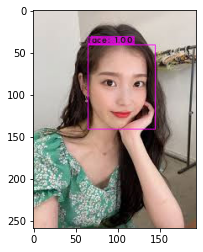

In [23]:
pred = plt.imread('predictions.jpg')
plt.imshow(pred)
plt.show()

# 얼굴 영역 crop한 파일 만들기

## 프로젝트 다운로드

In [24]:
%cd {HOME}
!git clone https://github.com/dhrim/darkeras-yolov4

/content
Cloning into 'darkeras-yolov4'...
remote: Enumerating objects: 168, done.
remote: Counting objects: 100% (168/168), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 168 (delta 83), reused 37 (delta 16), pack-reused 0
Receiving objects: 100% (168/168), 5.57 MiB | 9.57 MiB/s, done.
Resolving deltas: 100% (83/83), done.


In [25]:
%cd {HOME}
%cd darkeras-yolov4

/content
/content/darkeras-yolov4


## 데이터 다운로드

In [26]:
!rm -rf face
!unzip /gdrive/MyDrive/tmp/face/face.zip -d face

Archive:  /gdrive/MyDrive/tmp/face/face.zip
  inflating: face/etc_1.jpg          
  inflating: face/etc_1.txt          
  inflating: face/etc_10.jpg         
  inflating: face/etc_10.txt         
  inflating: face/etc_11.jpg         
  inflating: face/etc_11.txt         
  inflating: face/etc_13.jpg         
  inflating: face/etc_13.txt         
  inflating: face/etc_14.jpg         
  inflating: face/etc_14.txt         
  inflating: face/etc_15.jpg         
  inflating: face/etc_15.txt         
  inflating: face/etc_16.jpg         
  inflating: face/etc_16.txt         
  inflating: face/etc_2.jpg          
  inflating: face/etc_2.txt          
  inflating: face/etc_3.jpg          
  inflating: face/etc_3.txt          
  inflating: face/etc_4.jpg          
  inflating: face/etc_4.txt          
  inflating: face/etc_5.jpg          
  inflating: face/etc_5.txt          
  inflating: face/etc_6.jpg          
  inflating: face/etc_6.txt          
  inflating: face/etc_7.jpg          
  infl

## 모델 로딩

In [27]:
import yolov3_wrapper
detection_model = yolov3_wrapper.YoloV3Wrapper(GDRIVE_PATH+"/"+FACE_DETECTION_MODEL_FILE, class_num=1)

## 얼굴 탐지와 crop 이미지 저장

In [28]:
TARGET_PATH = "face"
CROPPED_PATH = TARGET_PATH+"/cropped"

In [29]:
!mkdir -p {CROPPED_PATH}

In [30]:
import glob
file_list = glob.glob(TARGET_PATH+"/*.jpg")
print(len(file_list))
print(file_list[:2])

46
['face/son_14.jpg', 'face/etc_4.jpg']


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def show_image(image):

    DPI = 80.
    height, width, depth = image.shape
    fig = plt.figure(figsize=(width/DPI, height/DPI))
    plt.imshow(image)
    plt.show()

def get_detection_cropped(model, image):

    bboxes = model.predict(image)

    cropped = []
    for box in bboxes:
        x1, y1, x2, y2 = box[:4].astype(np.int16)
        confidence = box[4]
        class_id = int(box[5])
        cropped.append(image[y1:y2,x1:x2,:])

    return cropped, bboxes

def save_cropped(path, file_name, i, cropped):

    new_name = path+"/"+ file_name.split("/")[-1].replace(".jpg", "_cropped_{}.jpg".format(i))
    plt.imsave(new_name, cropped)
    print("saved as {}".format(new_name))


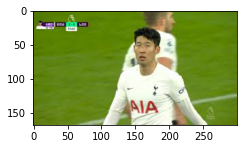

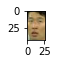

saved as face/cropped/son_14_cropped_0.jpg


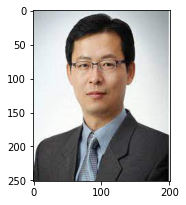

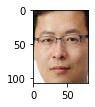

saved as face/cropped/etc_4_cropped_0.jpg


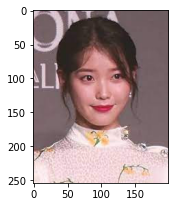

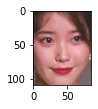

saved as face/cropped/iu_3_cropped_0.jpg


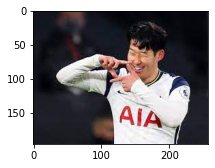

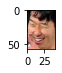

saved as face/cropped/son_1_cropped_0.jpg


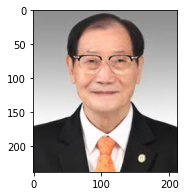

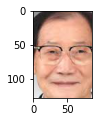

saved as face/cropped/etc_10_cropped_0.jpg


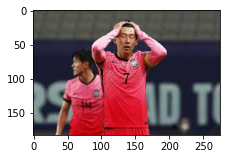

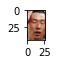

saved as face/cropped/son_8_cropped_0.jpg


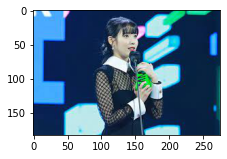

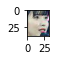

saved as face/cropped/iu_9_cropped_0.jpg


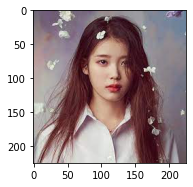

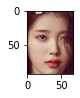

saved as face/cropped/iu_1_cropped_0.jpg


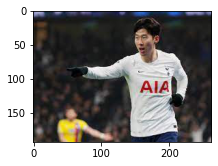

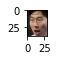

saved as face/cropped/son_6_cropped_0.jpg


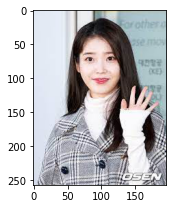

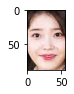

saved as face/cropped/iu_4_cropped_0.jpg


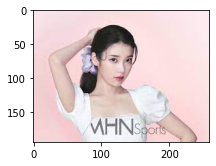

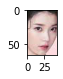

saved as face/cropped/iu_8_cropped_0.jpg


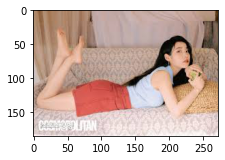

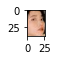

saved as face/cropped/iu_11_cropped_0.jpg


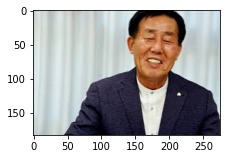

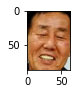

saved as face/cropped/etc_14_cropped_0.jpg


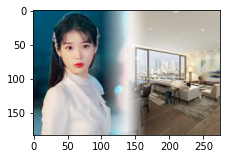

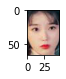

saved as face/cropped/iu_10_cropped_0.jpg


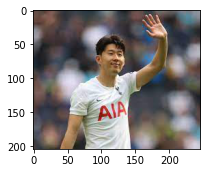

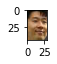

saved as face/cropped/son_3_cropped_0.jpg


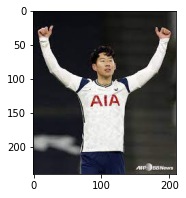

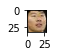

saved as face/cropped/son4_cropped_0.jpg


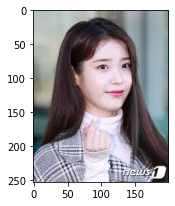

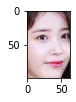

saved as face/cropped/iu_7_cropped_0.jpg


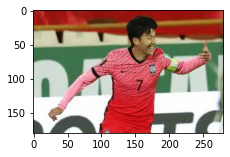

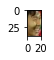

saved as face/cropped/son_11_cropped_0.jpg


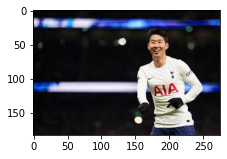

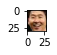

saved as face/cropped/son_10_cropped_0.jpg


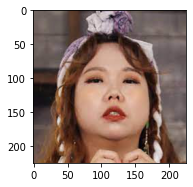

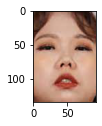

saved as face/cropped/etc_15_cropped_0.jpg


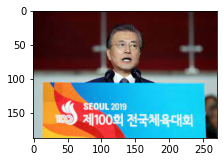

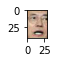

saved as face/cropped/etc_5_cropped_0.jpg


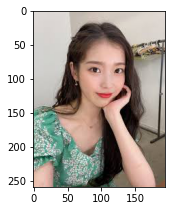

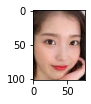

saved as face/cropped/iu_15_cropped_0.jpg


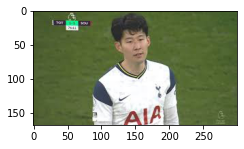

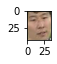

saved as face/cropped/son_9_cropped_0.jpg


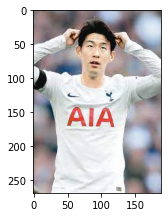

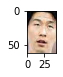

saved as face/cropped/son_2_cropped_0.jpg


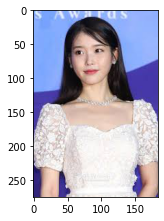

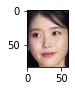

saved as face/cropped/iu_14_cropped_0.jpg


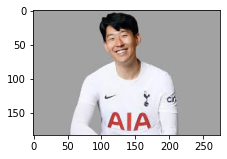

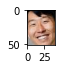

saved as face/cropped/son_15_cropped_0.jpg


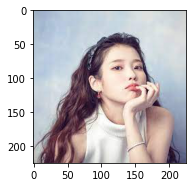

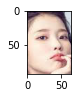

saved as face/cropped/iu_5_cropped_0.jpg


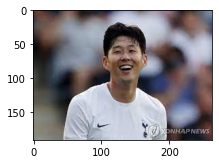

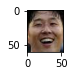

saved as face/cropped/son_7_cropped_0.jpg


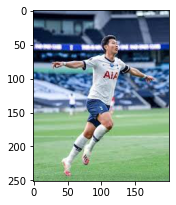

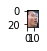

saved as face/cropped/son_13_cropped_0.jpg


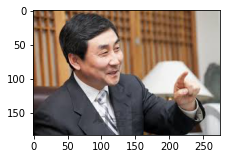

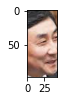

saved as face/cropped/etc_11_cropped_0.jpg


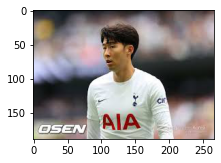

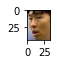

saved as face/cropped/son_16_cropped_0.jpg


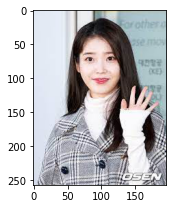

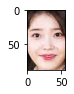

saved as face/cropped/iu_6_cropped_0.jpg


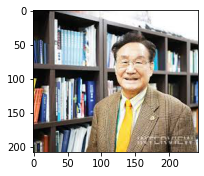

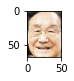

saved as face/cropped/etc_13_cropped_0.jpg


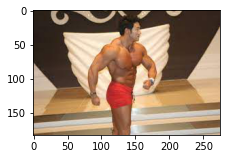

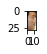

saved as face/cropped/etc_2_cropped_0.jpg


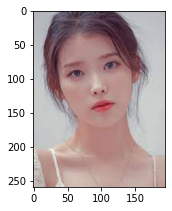

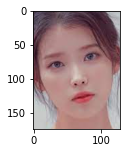

saved as face/cropped/iu_2_cropped_0.jpg


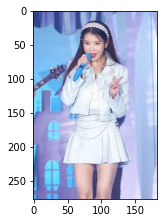

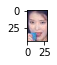

saved as face/cropped/iu_16_cropped_0.jpg


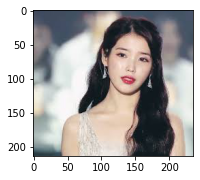

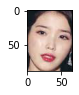

saved as face/cropped/iu_13_cropped_0.jpg


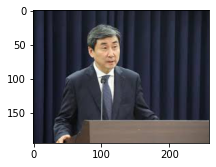

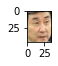

saved as face/cropped/etc_9_cropped_0.jpg


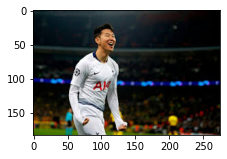

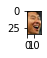

saved as face/cropped/son_12_cropped_0.jpg


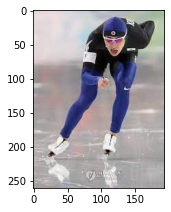

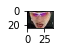

saved as face/cropped/etc_3_cropped_0.jpg


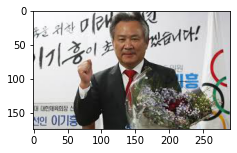

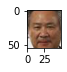

saved as face/cropped/etc_8_cropped_0.jpg


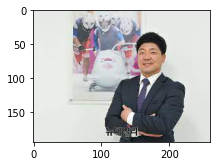

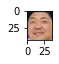

saved as face/cropped/etc_1_cropped_0.jpg


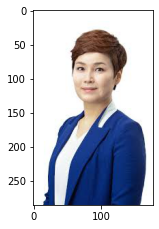

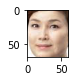

saved as face/cropped/etc_7_cropped_0.jpg


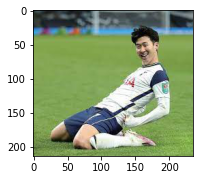

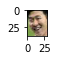

saved as face/cropped/son_5_cropped_0.jpg


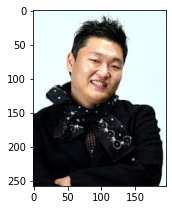

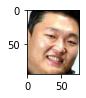

saved as face/cropped/etc_16_cropped_0.jpg


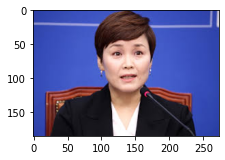

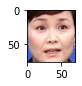

saved as face/cropped/etc_6_cropped_0.jpg


In [31]:
for file_name in file_list:

    image = plt.imread(file_name)
    show_image(image)

    croppeds, _ = get_detection_cropped(detection_model, image)

    for i, cropped in enumerate(croppeds):
        show_image(cropped)
        save_cropped(CROPPED_PATH, file_name, i, cropped)


# 인물 학습

## crop된 이미지로 학습 데이터 준비

In [32]:
!ls -al {CROPPED_PATH}

print()
print(CROPPED_PATH)

total 192
drwxr-xr-x 2 root root 4096 Jan 14 00:44 .
drwxr-xr-x 3 root root 4096 Jan 14 00:43 ..
-rw-r--r-- 1 root root 2789 Jan 14 00:44 etc_10_cropped_0.jpg
-rw-r--r-- 1 root root 1815 Jan 14 00:44 etc_11_cropped_0.jpg
-rw-r--r-- 1 root root 1862 Jan 14 00:44 etc_13_cropped_0.jpg
-rw-r--r-- 1 root root 2036 Jan 14 00:44 etc_14_cropped_0.jpg
-rw-r--r-- 1 root root 2678 Jan 14 00:44 etc_15_cropped_0.jpg
-rw-r--r-- 1 root root 2521 Jan 14 00:44 etc_16_cropped_0.jpg
-rw-r--r-- 1 root root 1184 Jan 14 00:44 etc_1_cropped_0.jpg
-rw-r--r-- 1 root root  788 Jan 14 00:44 etc_2_cropped_0.jpg
-rw-r--r-- 1 root root 1100 Jan 14 00:44 etc_3_cropped_0.jpg
-rw-r--r-- 1 root root 2560 Jan 14 00:44 etc_4_cropped_0.jpg
-rw-r--r-- 1 root root 1032 Jan 14 00:44 etc_5_cropped_0.jpg
-rw-r--r-- 1 root root 2043 Jan 14 00:44 etc_6_cropped_0.jpg
-rw-r--r-- 1 root root 1704 Jan 14 00:44 etc_7_cropped_0.jpg
-rw-r--r-- 1 root root 1390 Jan 14 00:44 etc_8_cropped_0.jpg
-rw-r--r-- 1 root root 1183 Jan 14 00:44 et

In [42]:
for class_name in class_names:
    full_path = TARGET_PATH+"/train/"+class_name
    print(full_path)
    !rm -rf {full_path}
    !mkdir -p {full_path}
    !cp {CROPPED_PATH}/{class_name}*.jpg {full_path}
    !ls -al {full_path}


face/train/etc
total 68
drwxr-xr-x 2 root root 4096 Jan 14 00:54 .
drwxr-xr-x 5 root root 4096 Jan 14 00:54 ..
-rw-r--r-- 1 root root 2789 Jan 14 00:54 etc_10_cropped_0.jpg
-rw-r--r-- 1 root root 1815 Jan 14 00:54 etc_11_cropped_0.jpg
-rw-r--r-- 1 root root 1862 Jan 14 00:54 etc_13_cropped_0.jpg
-rw-r--r-- 1 root root 2036 Jan 14 00:54 etc_14_cropped_0.jpg
-rw-r--r-- 1 root root 2678 Jan 14 00:54 etc_15_cropped_0.jpg
-rw-r--r-- 1 root root 2521 Jan 14 00:54 etc_16_cropped_0.jpg
-rw-r--r-- 1 root root 1184 Jan 14 00:54 etc_1_cropped_0.jpg
-rw-r--r-- 1 root root  788 Jan 14 00:54 etc_2_cropped_0.jpg
-rw-r--r-- 1 root root 1100 Jan 14 00:54 etc_3_cropped_0.jpg
-rw-r--r-- 1 root root 2560 Jan 14 00:54 etc_4_cropped_0.jpg
-rw-r--r-- 1 root root 1032 Jan 14 00:54 etc_5_cropped_0.jpg
-rw-r--r-- 1 root root 2043 Jan 14 00:54 etc_6_cropped_0.jpg
-rw-r--r-- 1 root root 1704 Jan 14 00:54 etc_7_cropped_0.jpg
-rw-r--r-- 1 root root 1390 Jan 14 00:54 etc_8_cropped_0.jpg
-rw-r--r-- 1 root root 1183 J

## 모델 학습

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 7, 7, 1408)       7768569   
                                                                 
 flatten_1 (Flatten)         (None, 68992)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               17662208  
                                                                 
 batch_normalization_73 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 25,432,572
Trainable params: 17,663,491
Non-trainable params: 7,769,081
__________________________________

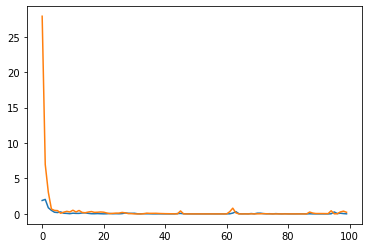

1/1 [==============================] - 0s 119ms/step - loss: 0.2315 - acc: 0.9565
loss= 0.23146750032901764
acc= 0.95652174949646


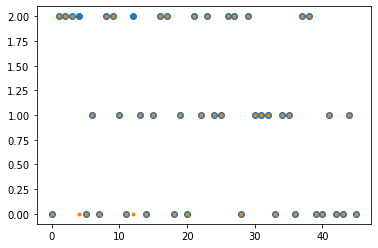

label category index = 0.0
predicted category index = 0
predicted category name = etc


In [44]:
import os

import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.applications import efficientnet
from tensorflow.keras.applications import EfficientNetB2

preprocessor = efficientnet.preprocess_input

conv_layers = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_layers.trainable = False

model = keras.Sequential()

model.add(conv_layers)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer="RMSprop", metrics=['acc'])
model.summary()

BATCH_SIZE = 64

train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
      preprocessing_function=preprocessor
).flow_from_directory(
      "face/train",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)

test_data_generator = ImageDataGenerator(
      preprocessing_function=preprocessor
).flow_from_directory(
      "face/train",
      target_size=(224,224),
      batch_size=BATCH_SIZE,
      class_mode='sparse'
)


history = model.fit(
      train_data_generator,
      validation_data=test_data_generator,
      epochs=100
)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()


loss, acc = model.evaluate(test_data_generator)
print("loss=", loss)
print("acc=", acc)



batch_x, batch_y = test_data_generator.next()
y_ = model.predict(batch_x)
predicted = np.argmax(y_, axis=-1)

plt.plot(batch_y[:100], "o")
plt.plot(predicted[:100], '.')
plt.show()


custom_labels = list(test_data_generator.class_indices.keys())
print("label category index =", batch_y[0])
print("predicted category index =", predicted[0])
print("predicted category name =", custom_labels[predicted[0]])


In [45]:
model.save(GDRIVE_PATH+"/"+FACE_CLASSIFICATION_MODEL_FILE)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


# 얼굴 인식

## 데이터 준비

In [8]:
!unzip {GDRIVE_PATH}/face_test.zip

Archive:  /gdrive/MyDrive/tmp/face/face_test.zip
   creating: face_test/
  inflating: face_test/iu_test_1.jpg  
  inflating: face_test/iu_test_3.jpg  
  inflating: face_test/iu_test_2.jpg  
  inflating: face_test/son_test_1.jpg  
  inflating: face_test/son_test_3.jpg  
  inflating: face_test/son_test_2.jpg  
  inflating: face_test/etc_test_3.jpg  
  inflating: face_test/etc_test_2.jpg  
  inflating: face_test/etc_test_1.jpg  


## 모델 로딩

In [4]:
%cd {HOME}
!git clone https://github.com/dhrim/darkeras-yolov4

/content
fatal: destination path 'darkeras-yolov4' already exists and is not an empty directory.


In [5]:
%cd {HOME}
%cd darkeras-yolov4

/content
/content/darkeras-yolov4


In [6]:
import yolov3_wrapper
detection_model = yolov3_wrapper.YoloV3Wrapper(GDRIVE_PATH+"/"+FACE_DETECTION_MODEL_FILE, class_num=1)

In [7]:
from tensorflow import keras
classificaiton_model = keras.models.load_model(GDRIVE_PATH+"/"+FACE_CLASSIFICATION_MODEL_FILE)

## 실행

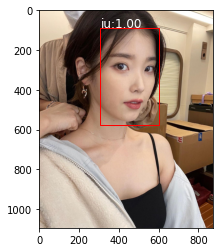

In [16]:
import matplotlib.patches as patches
import matplotlib.patheffects as patheffects

def classify(model, images):
    def resize(image):
        return cv2.resize(image, (224, 224))
    resizeds = np.array([ resize(image) for image in images ])
    y_ = model.predict(resizeds)
    class_ids = np.argmax(y_, axis=-1)
    confidences = np.max(y_, axis=-1)
    return class_ids, confidences

def draw_bbox(ax, bbox, class_name, confidence):
    x1, y1, x2, y2 = bbox[:4].astype(np.int16)
    rect = patches.Rectangle((x1,y1), x2-x1+1, y2-y1+1, linewidth=1, edgecolor='r',facecolor='none')
    plt.text(x1,y1, class_name+":"+"{0:.2f}".format(confidence), fontsize=12, color='white')
    ax.add_patch(rect)

def draw_bboxes(image, bboxes, class_ids, confidences):
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    for bbox, class_id, confidence in zip(bboxes, class_ids, confidences):
        draw_bbox(ax, bbox, class_names[class_id], confidence)
    plt.show()

def recognize(target_file_name):
    image = plt.imread(target_file_name)
    croppeds, bboxes = get_detection_cropped(detection_model, image)
    class_ids, confidences = classify(classificaiton_model, croppeds)
    draw_bboxes(image, bboxes, class_ids, confidences)

target_file_name = "iu_test_1.jpg"
recognize(target_file_name)


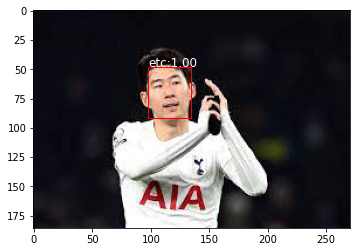

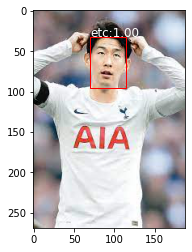

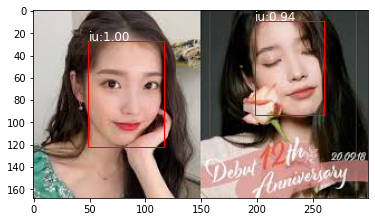

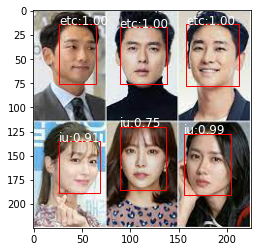

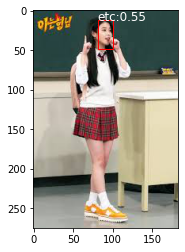

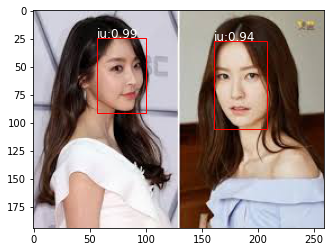

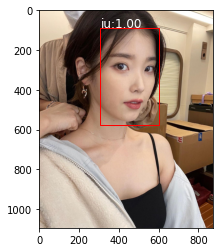

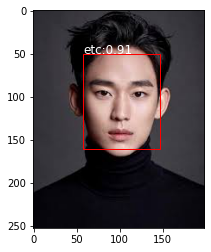

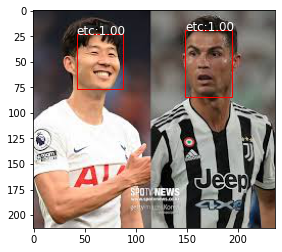

In [17]:
test_image_list = glob.glob("face_test/*[jpg|png|jpeg]")

for file_name in test_image_list:
    recognize(file_name)